# Тестовое задание Айдолон 
В этом задании предлагается провести небольшой анализ поведения игроков.

## Цель исследования:
выявить потенциально проблемные места в игре и предложить гипотезы по улучшению. 

## Описание полей:

|поле|описание|
|---|---|
|user_id|идентификатор игрока|
|event_dt|время, когда возникло событие|
|event_type|идентификатор типа события в текстовом виде|
|ver|версия приложения|
|country|ISO код страны игрока|
|area_id|идентификатор игровой зоны (зона состоит из уровней)|
|level_on_area_id|идентификатор уровня| 
|level_ver|версия уровня|
|tutorial_id|идентификатор туториала
|tutorial_action|тип действия в туториале
|tutorial_step|номер шага в туториале|
|level_session_id|идентификатор игровой сессии (сессия - это запуск уровня, действия на уровне и завершение уровня, все эти действия “прошиваются” одним идентификатором)|
|level_attempt|номер попытки запуска текущего уровня (1 - если первый раз)|
|used_items_before_start|предметы, использованные перед стартом уровня(json поле)|
|used_items_in_lvl|предметы, использованные во время игры на уровне (json поле)|
|payment_currency_0|размер платежа во внутренней валюте с индексом 0|
|payment_currency_1|размер платежа во внутренней валюте с индексом 1|
|payment_purchase|что было получено в результате платежа (json поле)|

## 0. Библиотеки

In [1]:
# базовые библиотеки
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import warnings
warnings.filterwarnings("ignore") 
from tqdm import tqdm_notebook
from scipy.sparse import hstack, vstack, csc_matrix
import os, re, sys, gc, pickle, time
from collections import defaultdict
from matplotlib import colors as mcolors
from itertools import combinations

## 0. Вспомогательные функции

In [2]:
def convert_types(df):
    '''конвертирует типы (по возможности)'''
    df_c = df.copy()
    for col in df.columns:
        ser = df[col]
        try:
            ser2 = ser.astype('datetime64')
            df_c[col] = ser2
        except:
            try:
                ser2 =ser.astype(np.float32)
                df_c[col] =ser2
            except:
                pass        
    return df_c

from sklearn.base import BaseEstimator, TransformerMixin,  clone
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
    
class SklearnHelperKmeans(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters
    def fit(self, X):
        _X = MinMaxScaler().fit_transform(X)
        inertias = []  
        self.labels = []
        for k in range(1, self.n_clusters+1):
            kmeanModel = KMeans(n_clusters=k)
            kmeanModel.fit(_X)                 
            inertias.append(kmeanModel.inertia_)
            self.labels.append(kmeanModel.labels_)
            
        pd.Series(inertias).plot(marker='.', color = 'black')
        plt.title('Elbow plot')
        plt.xlabel('k')
        plt.ylabel('distance')
        
        return self
    def transform(self, k):
        return self.labels[k-1]


## 0. Данные

In [3]:
PATH_TO_DATA = r'C:\Users\Sergey\anaconda3\Scripts\dataset.csv'

# преобразуем типы
df = convert_types(pd.read_csv(PATH_TO_DATA))

## 1. Первичный анализ
### 1.1. Отсутствующиее значения

In [4]:
# отсутствующие значения
nan_shares = df.isna().mean().sort_values()

In [5]:
print('{:<23} | {}'.format('признак', 'доля пропущенных значений'))
print('-------------------------------------------------------')
for k, v in nan_shares[nan_shares!=0].items():
    print('{:<23} | {:.1%}'.format(k, v))

признак                 | доля пропущенных значений
-------------------------------------------------------
country                 | 0.2%
tutorial_step           | 22.6%
tutorial_action         | 22.6%
tutorial_id             | 22.6%
level_on_area_id        | 23.3%
level_ver               | 27.0%
level_session_id        | 80.9%
level_attempt           | 81.0%
used_items_before_start | 81.0%
used_items_in_lvl       | 90.9%
payment_currency_0      | 96.3%
payment_purchase        | 96.3%
payment_currency_1      | 97.5%


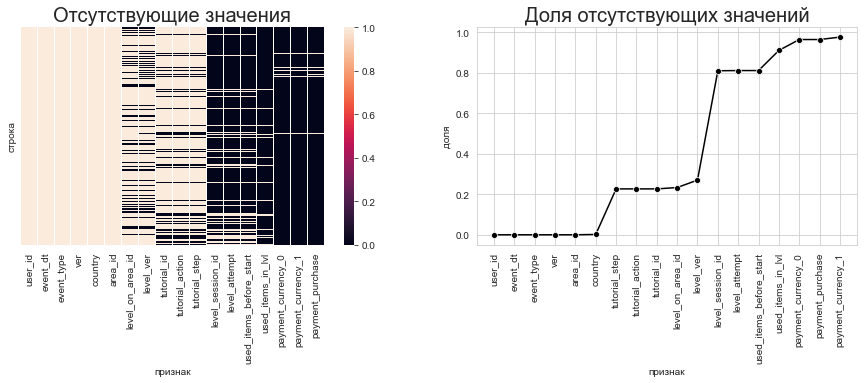

In [6]:
plt.figure(figsize = (15, 4))

plt.subplot(1, 2, 2)
sns.lineplot(data=nan_shares, x=nan_shares.index, y=nan_shares.values, marker='o', color='black')
plt.xticks(rotation=90)
plt.title('Доля отсутствующих значений', fontsize = 20)
plt.xlabel('признак')
plt.ylabel('доля')

plt.subplot(1, 2, 1)
sns.heatmap(df.notna())
plt.yticks([])
plt.title('Отсутствующие значения', fontsize = 20)
plt.xlabel('признак')
plt.ylabel('строка')

plt.show()

#### Выводы:
1. в столбце <mark>country</mark>  пропущено около 0.2% значений (возможно, их можно выбросить)
2. в столбцах <mark>tutorial_step, tutorial_action, tutorial_id</mark> пропущены около 23% значений (данные уровни не являются обучающими)
3. пропущенные значения в <mark>level_session_id</mark> - туториал или покупка в виртуальной валюте
4. пропущенные значения в <mark>level_attempt</mark> - попыток пройти уровень не было
5. пропущенные значения в <mark>payment_currency_0, payment_currency_1</mark> заполним 0 (платежей не было) 

### 1.2. Первичный анализ
#### 1.2.1. признаки по одному

In [7]:
user_id_counts = df['user_id'].value_counts()

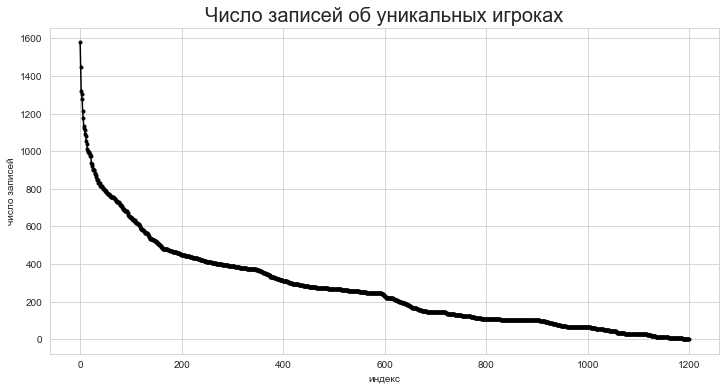

In [8]:
user_id_counts.reset_index(drop = True).plot(color='black', marker = '.', figsize = (12, 6))
plt.title('Число записей об уникальных игроках', fontsize = 20)
plt.xlabel('индекс')
plt.ylabel('число записей');

#### Выводы:
1. исключим слишком редких пользователй <mark>user_id</mark> (около 0.1% значений)

In [9]:
users_to_use = user_id_counts[user_id_counts>=user_id_counts.quantile(.05)].index
df = df.dropna(subset=['country'])
df = df[df['user_id'].isin(users_to_use)]

In [10]:
# парсим строковые данные
to_parse = ['used_items_before_start', 'used_items_in_lvl', 'payment_purchase']

# заменяем {} на np.nan
df[to_parse] = df[to_parse].replace({'{}':np.nan}).fillna('np.nan')

# проходим по строкам таблицы
for idx in tqdm_notebook(df.index):
    
    # проходим по строковым столбцам
    for col in to_parse:
        
        # парсим
        val = df.loc[idx, col]
        try:
            l_names, l_values = [], []
            for purch in val.split(','):        
                p = [i.strip() for i in purch.split(':')]        
                l_names.append(p[0][2:-1])
                l_values.append(np.float32(p[1][:-1]))
            counts = pd.concat([pd.Series(l_names), pd.Series(l_values)], 1).groupby(0)[1].sum()
            for k, v in counts.items():
                df.loc[idx, f'{col}.{k}'] = v
        except:
            pass
        
df = df.drop(to_parse, 1)
df.loc[:, df.columns.str.contains('purchase')] =\
    df.loc[:, df.columns.str.contains('purchase')].fillna(0)
df.loc[:, df.columns.str.contains('used_items_in_lvl')] = \
    df.loc[:, df.columns.str.contains('used_items_in_lvl')].fillna(0)
df.loc[:, df.columns.str.contains('used_items_before_start')] = \
    df.loc[:, df.columns.str.contains('used_items_before_start')].fillna(0)

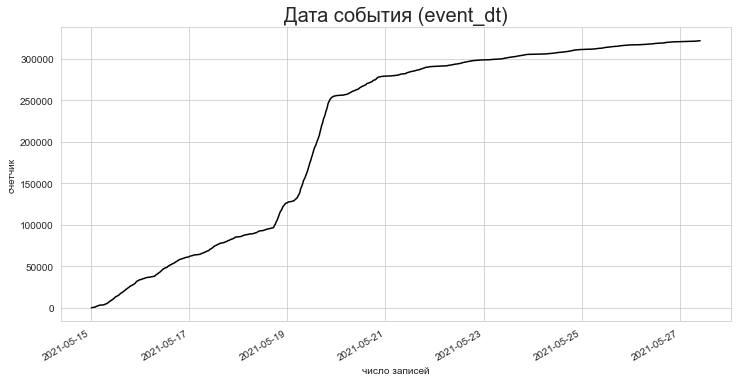

In [20]:
pd.Series(index= df['event_dt'].sort_values().values).fillna(1).cumsum().plot(color = 'black', figsize = (12, 6))
plt.title('Дата события (event_dt)', fontsize = 20)
plt.xlabel('число записей')
plt.ylabel('счетчик')
plt.show()

In [21]:
mask = ~df.columns.str.contains('purchase.')

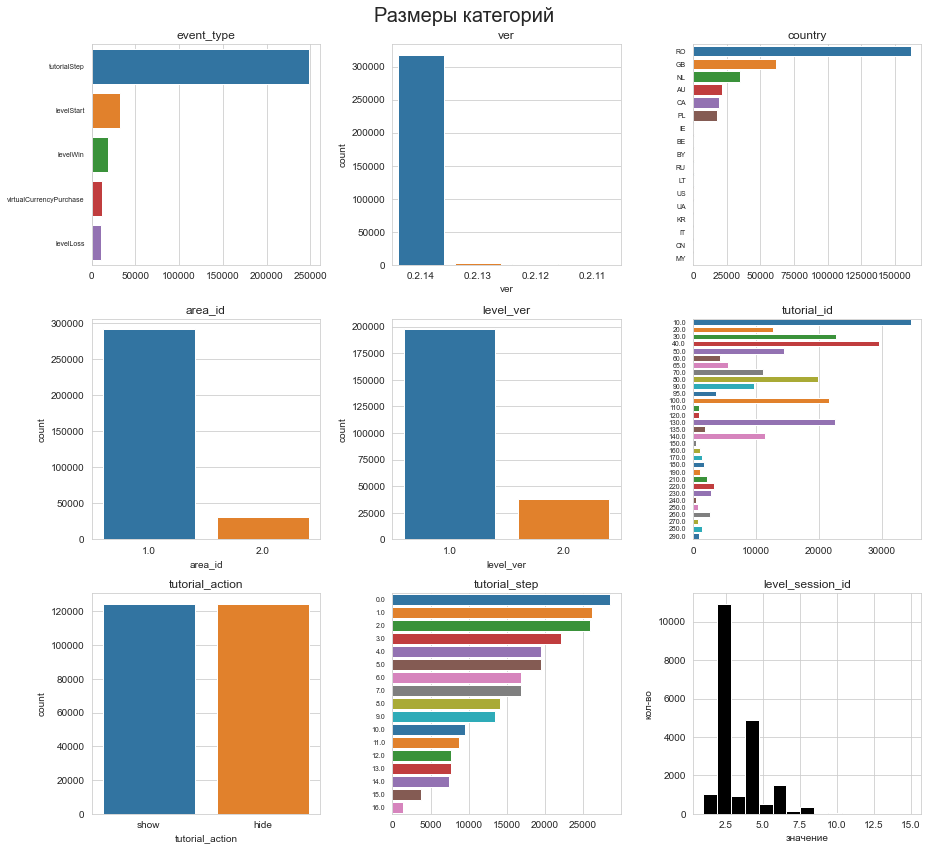

In [209]:
plt.figure(figsize=(13, 12))
plt.suptitle('Размеры категорий', fontsize = 20)
for i, col in enumerate(['event_type', 'ver', 'country',\
                         'area_id', 'level_ver', 'tutorial_id',\
                         'tutorial_action', 'tutorial_step', 'level_session_id']):
    ser = df[col]   
    vc = ser.value_counts()
    
    if col not in ('event_type', 'tutorial_id', 'country', 'tutorial_step', 'level_session_id', 'level_attempt'):
        plt.subplot(3, 3, i+1)    
        sns.countplot(ser, order = vc.index, palette="tab10")
        plt.title(col)
    else:   
        if col not in ('level_session_id'):        
            plt.subplot(3, 3, i+1)
            sns.barplot(y=vc.index, x = vc.values,orient='h', palette="tab10")
            plt.title(col)
            plt.yticks(fontsize=7)
        else:
            ax = plt.subplot(3, 3, i+1)
            df[col].value_counts().hist(color = 'black', bins = 15, ax=ax)
            plt.title(col)
            plt.xlabel('значение')
            plt.ylabel('кол-во')
        
plt.subplots_adjust(hspace=.4)
plt.tight_layout()

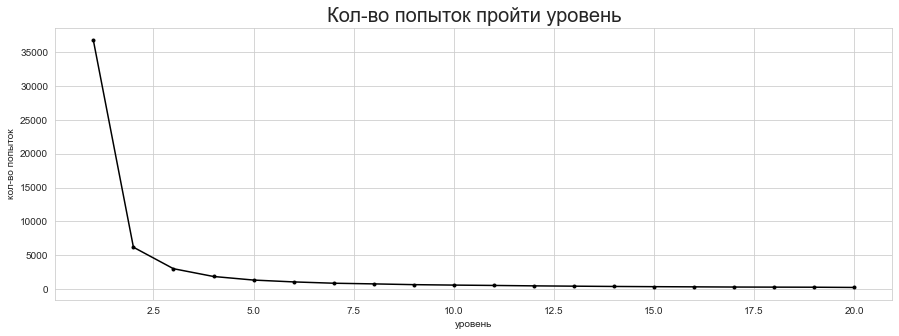

In [235]:
df['level_attempt'].value_counts().sort_index().head(20).plot(color='black', marker='.', figsize = (15,5))
plt.title('Кол-во попыток пройти уровень', fontsize = 20)
plt.ylabel('кол-во попыток')
plt.xlabel('уровень');

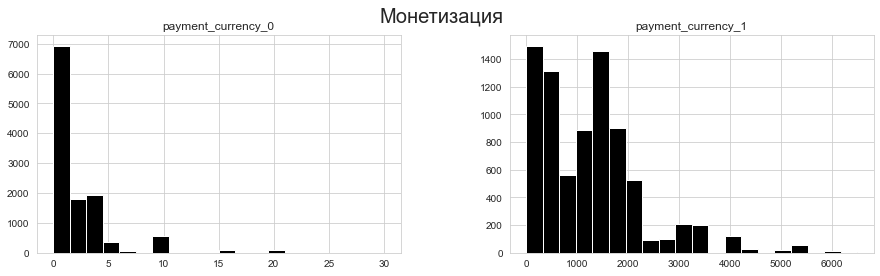

In [249]:
df[['payment_currency_0', 'payment_currency_1']].hist(color='black', bins=20, figsize = (15, 4))
plt.suptitle('Монетизация', fontsize = 20);

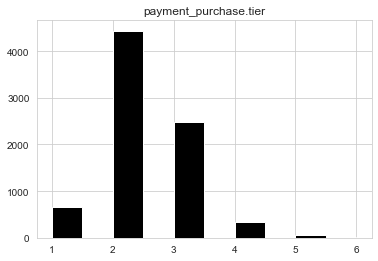

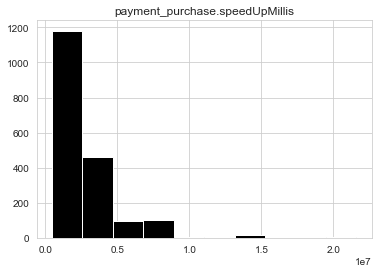

In [279]:
for col in ['used_items_before_start', 'payment_purchase']:
    subdf = df[df.columns[df.columns.str.contains(col)]]
    nuniques = subdf.replace({0:np.nan}).nunique()    
    for col2 in nuniques[nuniques!=1].index:
        subdf[col2][subdf[col2]!=0].hist(color='black')
        plt.title(col2)
        plt.show()
            

#### Выводы:
1. кол-во обучающих уровней(<mark>event_type</mark>) значительно больше кол-ва остальных (или этап обучения слишком длинный, или игровой этап слишком скучный)
2. почти все версии уровней(<mark>ver</mark>)-0.2.14(последняя версия)
3. большая часть игроков из RO(<mark>country</mark>) (игра производилась там?)
4. большая часть уровней - 1-ой версии (<mark>level_ver</mark>)
5. туториалы проходятся с разной частотой (<mark>tutorial_id</mark>)
6. первый уровень проходится очень тяжело <mark>level_attempt</mark>
7. кроме малых сумм, популярны средние суммы донатов (<mark>payment_currency_1</mark>)

#### 1.2.2. взаимодействия признаков

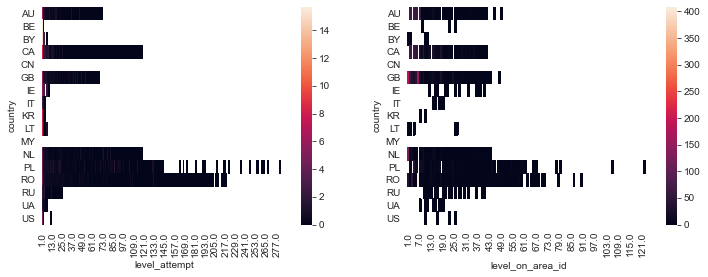

In [561]:
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
sns.heatmap(df.groupby(['country', 'level_attempt']).apply(lambda x: (x['event_type']=='levelWin').sum() /\
                                                                     (x['event_type']=='levelLoss').sum()).unstack()\
                                                    .replace({np.inf:np.nan}))

plt.subplot(1, 2, 2)
sns.heatmap(df.groupby(['country', 'level_on_area_id']).apply(lambda x: (x['event_type']=='levelWin').sum() /\
                                                                        (x['event_type']=='levelLoss').sum()).unstack()\
                                                      .replace({np.inf:np.nan}))
plt.show()

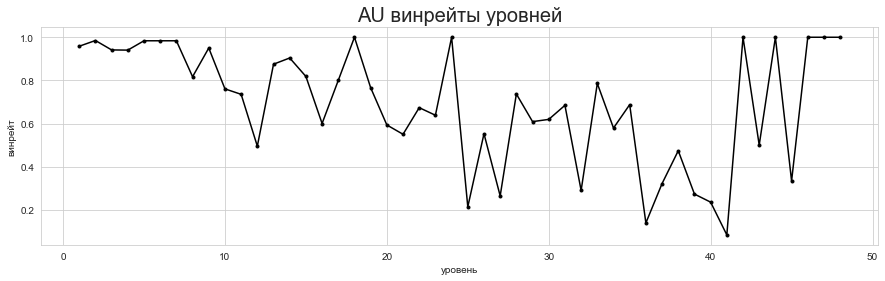

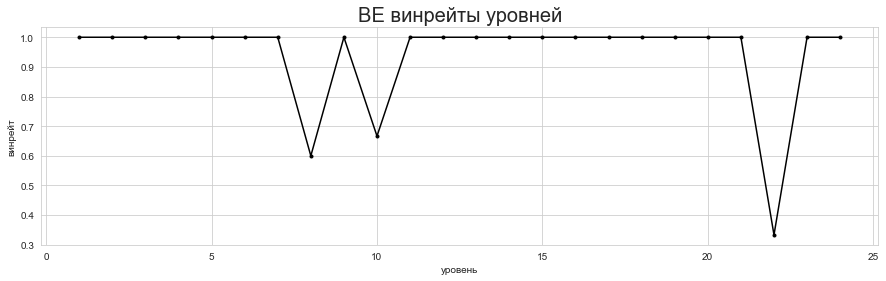

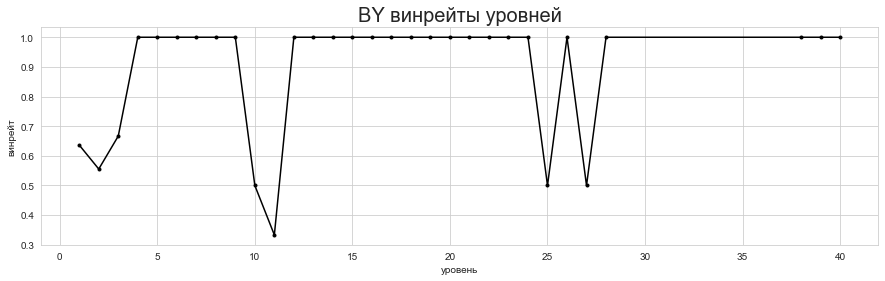

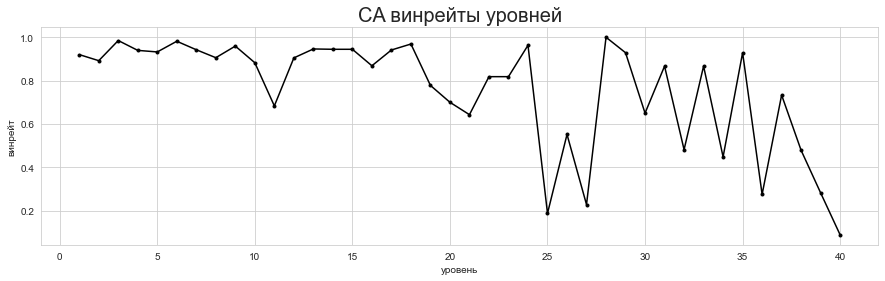

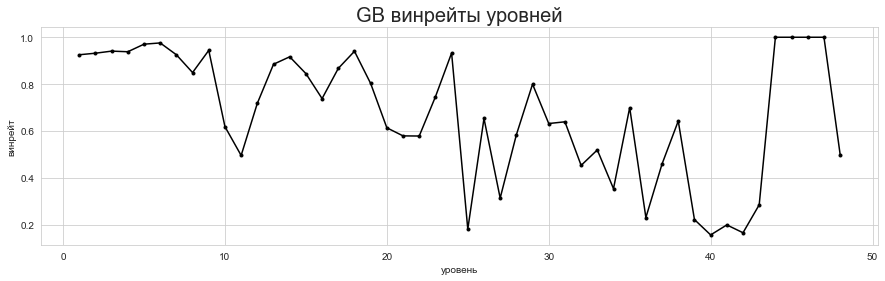

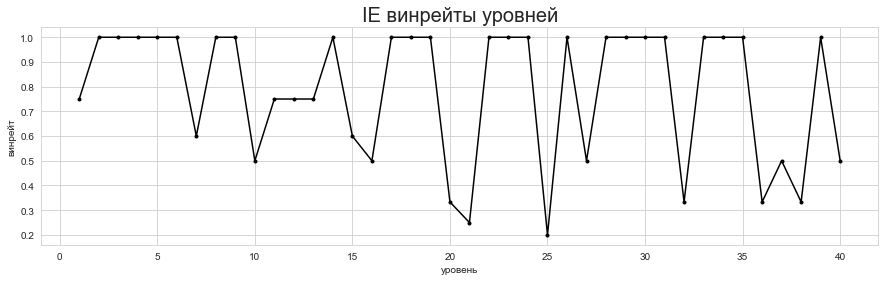

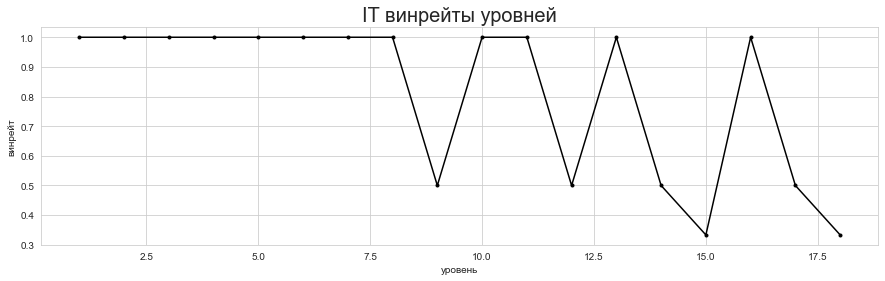

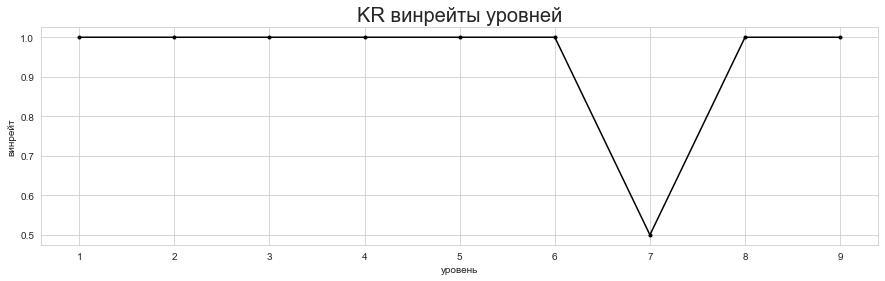

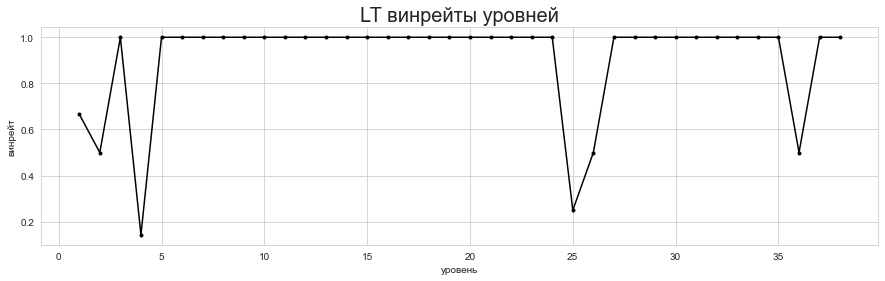

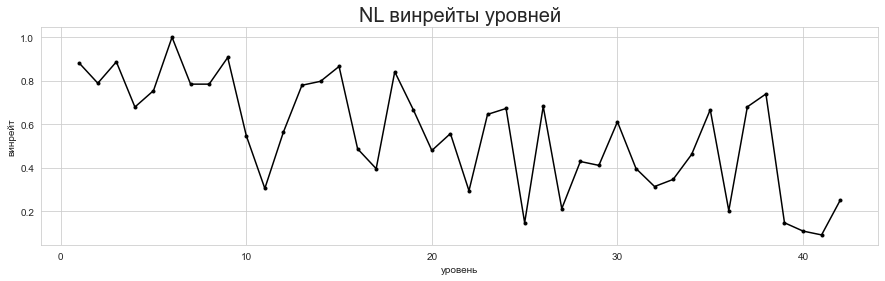

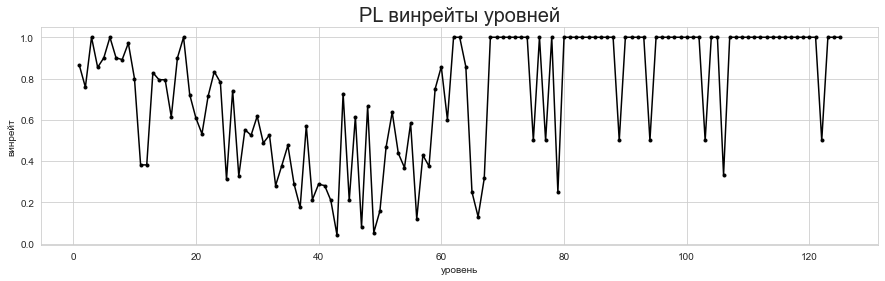

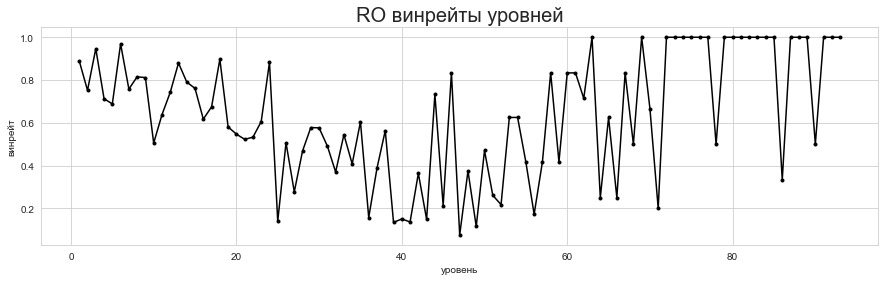

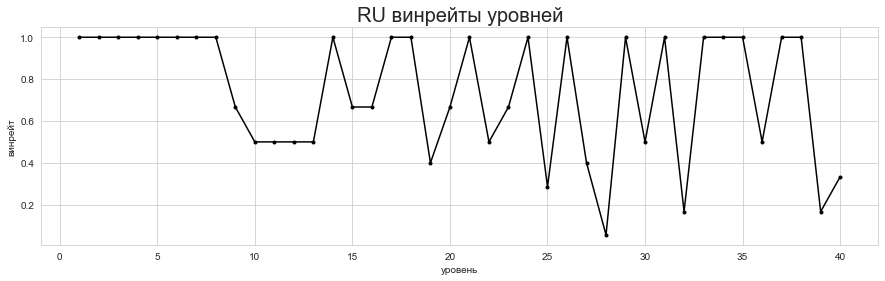

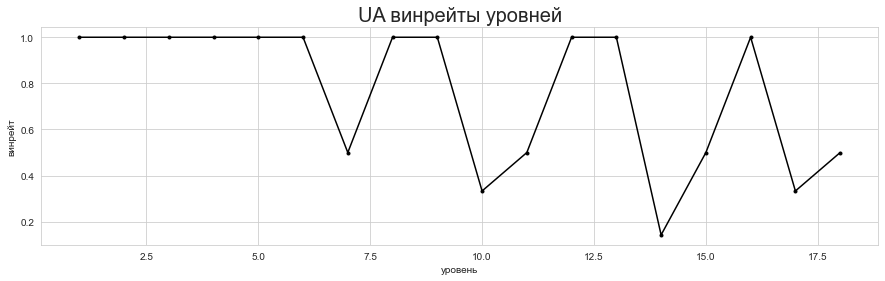

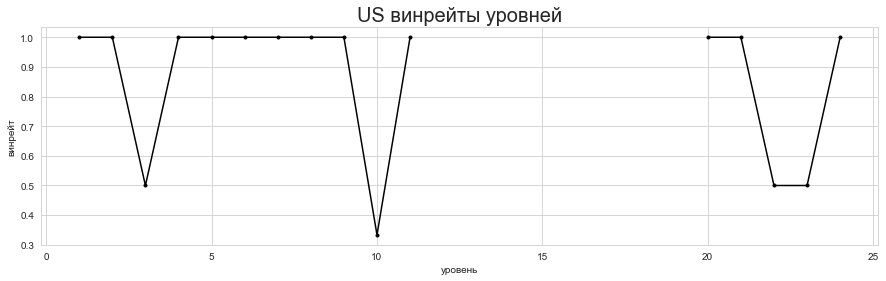

In [562]:
s = df.groupby('country').size()
for country in s[s>100].index:
    try:
        df_event_type_level = df[df['country'] == country]\
                                .groupby(['event_type', 'level_on_area_id']).size().unstack().T.iloc[:, :-2]
        (df_event_type_level['levelWin'] / df_event_type_level['levelStart'])\
            .plot(color = 'black', marker='.', figsize = (15, 4))
        plt.title(f'{country} винрейты уровней', fontsize = 20)
        plt.xlabel('уровень')
        plt.ylabel('винрейт')
        plt.show()
    except:
        pass

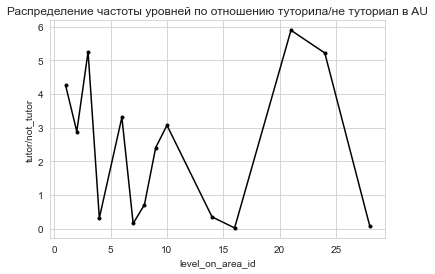

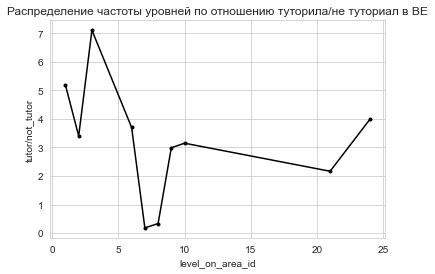

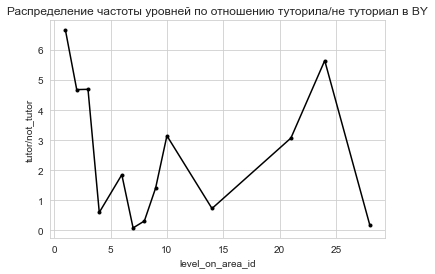

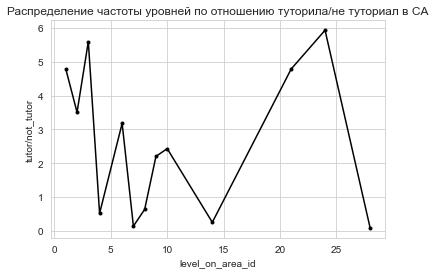

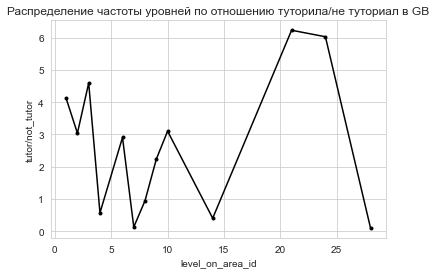

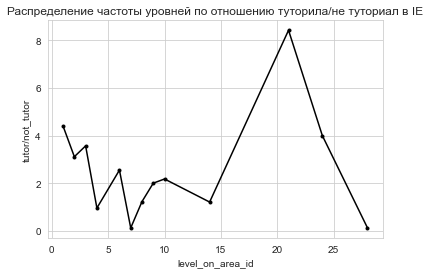

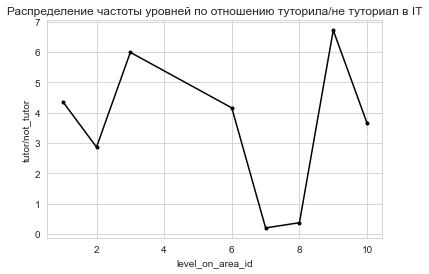

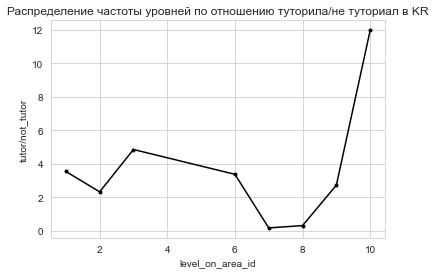

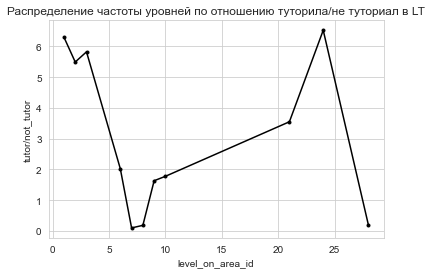

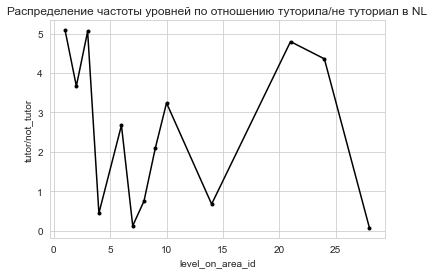

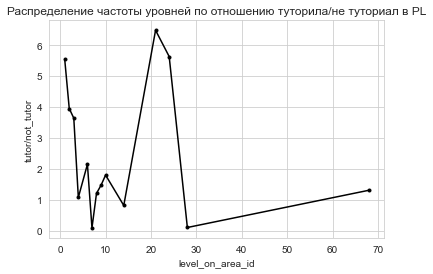

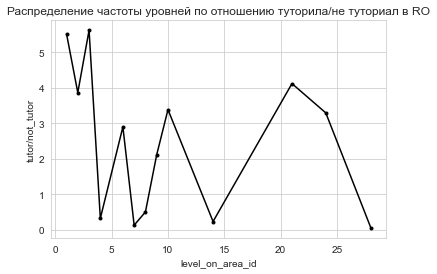

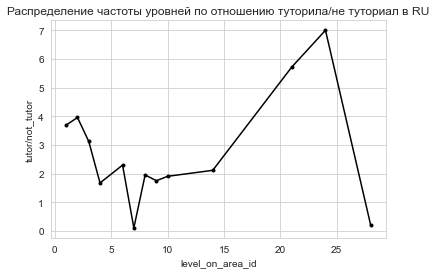

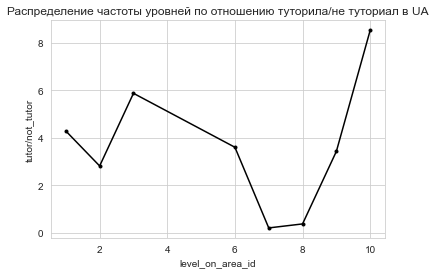

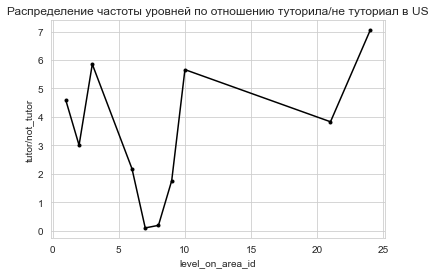

In [591]:
for country in s[s>100].index:
    ser_tutor = df[(df['event_type']=='tutorialStep') & (df['country']==country)]\
                    ['level_on_area_id'].value_counts(normalize = True)
    ser_not_tutor = df[df['event_type']!='tutorialStep']['level_on_area_id'].value_counts(normalize = True)\
                    .loc[ser_tutor.index]
    (ser_tutor / ser_not_tutor).sort_index().plot(color = 'black', marker = '.')
    plt.title(f'Распределение частоты уровней по отношению туторила/не туториал в {country}')
    plt.xlabel('level_on_area_id')
    plt.ylabel('tutor/not_tutor')
    plt.show()

#### Выводы:
1. винрейты уровней и повторых попток пройти уровень меняются от страын к стране
2. из-за разных распределений сложности уровней в регионах, частоты туториалов и основных уровне отличаются

### 1.3. Агрегируем статистики в разрезе пользователей
1. распределения event_type
2. доля обучаего этапа tutorial_share
3. число уникальных сессий
4. максимальный уровень медианная продолжительность сессий
5. длительность обучаующего этапа
6. доля разорвавшихся соединений
7. кол-во сессий по длительностям
8. суммарный донат
9. повторные попытки

In [599]:
L_aggs = []
for user_id, subdf in tqdm_notebook(df.groupby('user_id')):
    
    agg_df = subdf['event_type'].value_counts(normalize = True).to_frame(user_id).T.add_prefix('event_type.')
    agg_df['tutorial_share'] = subdf['level_session_id'].isna().mean()
    agg_df['n_session'] = subdf['level_session_id'].nunique()    
    
    for col in ['ver', 'country', 'area_id']:        
        try:
            try:
                agg_df[col] = ','.join([x.astype(str) for x in subdf[col].unique()])
            except:
                agg_df[col] = ','.join(subdf[col].unique())
        except:
            agg_df[col] = None
        
    agg_df['level_on_area_id.max'] = subdf['level_on_area_id'].max()
    agg_df['level_ver==1.share'] = (subdf['level_ver'].dropna()==1).mean()    
    agg_df['tutorial_id.nunique'] = subdf['tutorial_id'].dropna().nunique()
    
    s = subdf[['level_session_id', 'tutorial_id']].sum(1).to_frame('sess_id')
    subdf['sess_id'] = s
    s['event_dt'] = subdf['event_dt']
    durations = s.groupby('sess_id')['event_dt'].apply(lambda x: (x.max()-x.min())/np.timedelta64(1, 's'))

    try:
        agg_df['event_dt.purchase_duration(sec)'] = durations.loc[0]
    except:
        pass

    try:
        agg_df['event_dt.mean_durations(sec)'] = durations.drop(0).median()
    except:
        agg_df['event_dt.mean_durations(sec)'] = durations.median()
        
    agg_df['event_dt.disconnect_share'] = (durations==0).mean()
    agg_df['event_dt.1min_share'] = ((durations!=0) & (durations<60*1)).mean()
    
    maxdur = 11
    for i in range(1, maxdur):
        agg_df[f'event_dt.{i+1}min_share'] = ((durations>=60*i) & (durations<60*(i+1))).mean()
    agg_df[f'event_dt.{maxdur+1}+min_share'] = (durations>=60*(maxdur+1)).mean()    
    
    agg_df['tutorial_id.nunique'] = subdf['tutorial_id'].nunique()
    
    for k, v in subdf['tutorial_action'].value_counts(normalize = True).items():
        agg_df[f'tutorial_action.{k}'] = v
        
    agg_df['tutorial_step.max'] = subdf['tutorial_step'].max()
    
    for k, v in subdf['level_attempt'].value_counts().items():
        agg_df[f'level_attempt.{k}'] = v
        
    df_payments = subdf.groupby('sess_id')[['payment_currency_0', 'payment_currency_1']].sum()
    try:
        for k, v in df_payments.drop(0).sum().items():
            agg_df[f'{k}.sum'] = v
    except:
        for k, v in df_payments.sum().items():
            agg_df[f'{k}.sum'] = v    
        
    L_aggs.append(agg_df)
    
    
    
df_aggs = pd.concat(L_aggs)
ll = df_aggs.columns[df_aggs.columns.str.contains('min')]
df_aggs = pd.concat([df_aggs.drop(ll, 1),\
                     df_aggs[ll[np.argsort([np.float32(re.findall(r'\d+', el))[0] for el in ll])]]], 1)
df_aggs = pd.concat([df_aggs[df_aggs.columns[~df_aggs.columns.str.contains('event_dt')]],\
                     df_aggs[df_aggs.columns[df_aggs.columns.str.contains('event_dt')]]], 1)   
df_aggs = pd.concat([df_aggs[df_aggs.columns[~df_aggs.columns.str.contains('attempt')]],\
                     df_aggs[df_aggs.columns[df_aggs.columns.str.contains('attempt')]]], 1)    

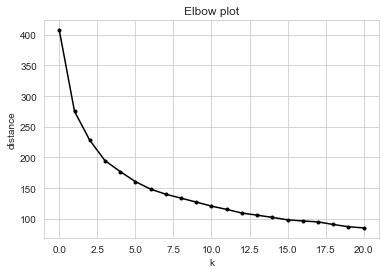

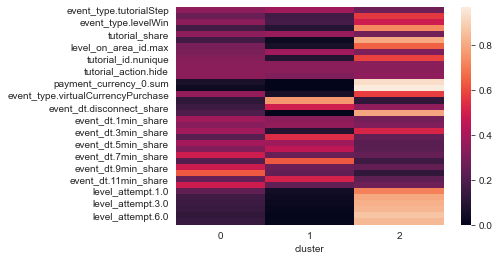

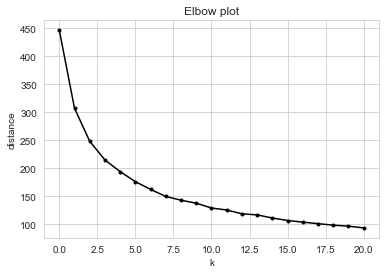

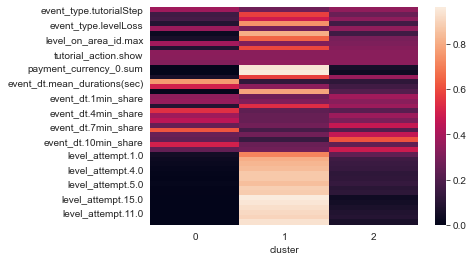

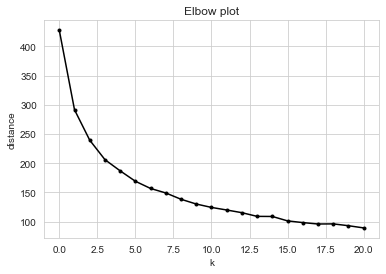

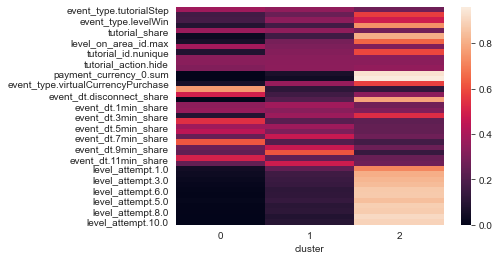

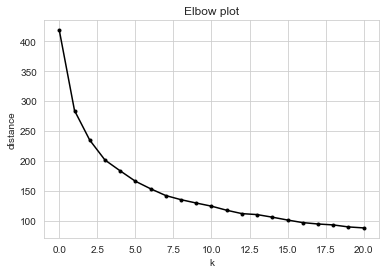

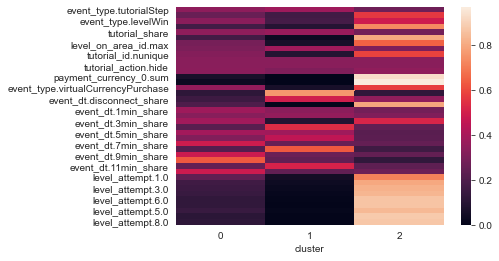

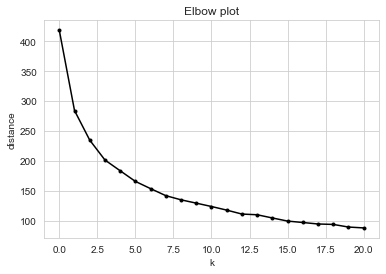

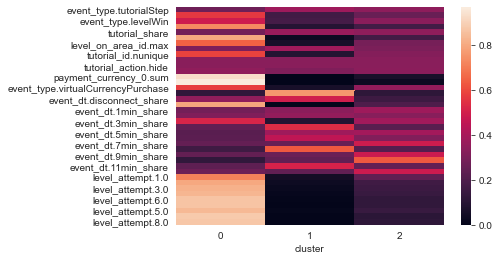

In [653]:
for country in ['RO', 'GB', 'NL', 'AU', 'CA']:
    df_num = df_aggs[df_aggs['country'] == country].select_dtypes('number')
    df1 = df_RO_num.loc[:, df_num.isna().mean()<.8].fillna(0)
    
    kmeans_20 = SklearnHelperKmeans(n_clusters=21)
    scaler = MinMaxScaler()
    kmeans_20.fit(scaler.fit_transform(df1))
    plt.show()
    
    df1['cluster'] = kmeans_20.transform(3)
    
    report = df1.groupby('cluster').mean().T
    sns.heatmap(report.apply(lambda x: x/report.sum(1)) )
    plt.show()

#### Видно, что кластеры игроков в различных регионах имеют свои особенности